## T019 Molecular dynamics simulation
* https://projects.volkamerlab.org/teachopencadd/talktorials/T019_md_simulation.html

### TOC
#### 1. Preparation of complex pbd
* Download PDB file
* Prepare the protein ligand complex
    * Protein preparation
    * Ligand preparation
    * Merge protein and ligand

#### 2. Create system for MD simulation
* MD simulation set up
    * Force field
    * System - protein, ligand, water, ions
#### 3. Run MD simulation
* Perform the MD simulation
* Download results

### Some tips
* For simulations under periodic boundary conditions, it is recommended to use a simulation box large enough, so that the simulated macromolecule does not come into contact with neighboring images of itself.

### Advantage of MD simulation
* MD give valuable insights into the highly dynamic process of ligand binding to their target.
* ligands may induce conformational changes in the macromolecule that can best accommodate the small molecule.
    * binding sites that are not observed in static ligand-free structures, but can be discovered with MD simulations, are sometimes called cryptic binding sites.
    * The identification of such binding sites with MD simulation can kickstart new drug discovery campaigns.
* Later in the drug discovery process, MD simulations can also be used to estimate the quality of computationally identified small molecules before performing more costly and time-intensive in vitro tests. 


In [18]:
# Load libaries
import copy
import sys
from pathlib import Path

import requests
from IPython.display import display
import numpy as np
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
import mdtraj as md
import pdbfixer
import nglview as nv
import openmm as mm
import openmm.app as app
from openmm import unit
from openff.toolkit.topology import Molecule, Topology
from openmmforcefields.generators import GAFFTemplateGenerator


In [2]:
# create data directory if not exists
data_dir = Path("./data/EGPR_tutorial")
Path(data_dir).mkdir(parents=True, exist_ok=True)
result_dir = Path("./results/EGPR_tutorial")
Path(result_dir).mkdir(parents=True, exist_ok=True)

In [3]:

pdbid = "3POZ" # EGFR kinase domain
ligand_name = "03P"
# check the complex structure
complex_path = str(result_dir / f"{pdbid}_{ligand_name}_complex.pdb")
complex_view = nv.show_structure_file(complex_path)
complex_view.add_representation("ball+stick", selection="not protein")
complex_view.add_representation("cartoon", selection="protein")
complex_view.add_representation("licorice", selection="water")
complex_view.add_representation("unitcell")
complex_view.camera = "orthographic"
complex_view

NGLWidget()

In [4]:
# Load the complex structure using OpenMM
complex_pdb = app.PDBFile(complex_path)
complex_topology, complex_positions = complex_pdb.topology, complex_pdb.positions


### Force field
* Common force fields like AMBER have parameters for amino acids, nucleic acids, water and ions and usually offer several options to choose from depending on your aim. 
* We use the amber14-all.xml force field file, which is shipped with OpenMM and includes parameters for proteins, DNA, RNA and lipids. For solvation we use the standard three-site water model TIP3P.

* Parameters for ligands however are not included. To generate these parameters, we can use the General AMBER ForceField (GAFF), which is implemented in the Python package OpenMM Forcefields. The following function generates a force field object holding standard AMBER parameters and additionally includes parameters for a small molecule if required.

In [5]:
def generate_forcefield(
    rdkit_mol=None, protein_ff="amber14-all.xml", solvent_ff="amber14/tip3pfb.xml"
):
    """
    Generate an OpenMM Forcefield object and register a small molecule.

    Parameters
    ----------
    rdkit_mol: rdkit.Chem.rdchem.Mol
        Small molecule to register in the force field.
    protein_ff: string
        Name of the force field.
    solvent_ff: string
        Name of the solvent force field.

    Returns
    -------
    forcefield: openmm.app.Forcefield
        Forcefield with registered small molecule.
    """
    forcefield = app.ForceField(protein_ff, solvent_ff)

    if rdkit_mol is not None:
        gaff = GAFFTemplateGenerator(
            molecules=Molecule.from_rdkit(rdkit_mol, allow_undefined_stereo=True)
        )
        forcefield.registerTemplateGenerator(gaff.generator)

    return forcefield

In [6]:
rcsb_ligand = Chem.MolFromMolFile(str(result_dir / f"{ligand_name}_prepared.mol"))
forcefield = generate_forcefield(rcsb_ligand)

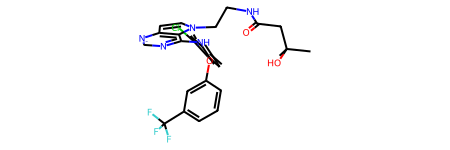

In [7]:
rcsb_ligand

### Create a system
* a simulation box which contains the complex and is filled with a solvent.
* The standard solvent is water with a specified amount of ions
* We define it with a padding, which results in a cubic box with dimensions dependent on the largest dimension of the complex.

In [8]:
modeller = app.Modeller(complex_topology, complex_positions)
modeller.addSolvent(forcefield, padding=1.0 * unit.nanometers, ionicStrength=0.15 * unit.molar)
# this step may take several minutes (~ 5 min)

In [9]:
with open(str(result_dir / f"{pdbid}_{ligand_name}_solvated.pdb"), "w") as f:
    app.PDBFile.writeFile(modeller.topology, modeller.positions, f)

In [10]:
print("Complex topology has", modeller.topology.getNumAtoms(), "atoms.")

Complex topology has 52862 atoms.


In [11]:
system = forcefield.createSystem(modeller.topology, nonbondedMethod=app.PME)#,
            #nonbondedCutoff=1.0*unit.nanometers, #constraints=app.HBonds, rigidWater=True,
            #ewaldErrorTolerance=0.0005)
# when creating the system, it uses all the cpu cores available.

In [13]:
for force in system.getForces():
    if isinstance(force, mm.NonbondedForce):
        for i in range(system.getNumParticles()):
            charge, sigma, epsilon = force.getParticleParameters(i)
            print(f"Atom {i}: Charge = {charge}")

Atom 0: Charge = 0.1493 e
Atom 1: Charge = 0.1996 e
Atom 2: Charge = 0.1996 e
Atom 3: Charge = 0.1996 e
Atom 4: Charge = 0.0536 e
Atom 5: Charge = 0.1015 e
Atom 6: Charge = 0.6123 e
Atom 7: Charge = -0.5713 e
Atom 8: Charge = 0.0651 e
Atom 9: Charge = 0.005 e
Atom 10: Charge = 0.005 e
Atom 11: Charge = -0.0903 e
Atom 12: Charge = 0.0331 e
Atom 13: Charge = 0.0331 e
Atom 14: Charge = 0.7354 e
Atom 15: Charge = -0.6133 e
Atom 16: Charge = -1.0031 e
Atom 17: Charge = 0.4429 e
Atom 18: Charge = 0.4429 e
Atom 19: Charge = -0.4157 e
Atom 20: Charge = 0.2719 e
Atom 21: Charge = 0.0337 e
Atom 22: Charge = 0.0823 e
Atom 23: Charge = 0.5973 e
Atom 24: Charge = -0.5679 e
Atom 25: Charge = -0.1825 e
Atom 26: Charge = 0.0603 e
Atom 27: Charge = 0.0603 e
Atom 28: Charge = 0.0603 e
Atom 29: Charge = -0.4157 e
Atom 30: Charge = 0.2719 e
Atom 31: Charge = -0.0518 e
Atom 32: Charge = 0.0922 e
Atom 33: Charge = 0.5973 e
Atom 34: Charge = -0.5679 e
Atom 35: Charge = -0.1102 e
Atom 36: Charge = 0.0457 e
At

In [14]:
# when creating the system, it uses all the cpu cores available.
integrator = mm.LangevinIntegrator(
    300 * unit.kelvin, 1.0 / unit.picoseconds, 2.0 * unit.femtoseconds
)
#integrator.setConstraintTolerance(0.00001)
platform = mm.Platform.getPlatformByName("CUDA")
simulation = app.Simulation(modeller.topology, system, integrator, platform)
simulation.context.setPositions(modeller.positions)

In [15]:
# minimize the energy
print('Minimizing...')
simulation.minimizeEnergy()

Minimizing...


In [16]:
with open(str(result_dir / f"{pdbid}_{ligand_name}_minimized.pdb"), "w") as f:
    app.PDBFile.writeFile(simulation.topology, 
                          simulation.context.getState(getPositions=True, enforcePeriodicBox=True).getPositions(), 
                          f, 
                          keepIds=True)
# for analysis, we need to save the minimized structure.

In [17]:
# equilibrate for 100 steps
simulation.context.setVelocitiesToTemperature(300*unit.kelvin)
print('Equilibrating...')
simulation.step(100)

Equilibrating...


In [19]:
# append reporters
# you can save the trajectory with dcd or xtc format.
# xtc is compressed (GROMACS trajectory)
# dcd is not compressed (CHARMM trajectory), it consumes more disk space 3 times.
simulation.reporters.append(
    app.XTCReporter(str(result_dir / f"{pdbid}_{ligand_name}_3rd_trajectory.xtc"), 
                reportInterval=1000))
simulation.reporters.append(
    app.StateDataReporter(sys.stdout, 
                          reportInterval=1000,
                          step=True, 
                          potentialEnergy=True, 
                          temperature=True, 
                          progress=True, 
                          remainingTime=True, 
                          speed=True, 
                          totalSteps=250000, # 2 fs * 250000 = 500 ps
                          separator='\t'))

In [20]:
# run 0.5 ns of production simulation, it takes about 7 min
# for 50 ns, it takes about 12 hrs on a single GPU (RTX A2000 in HP server)
print('Running Production...')
simulation.step(250000)
print('Done!')

Running Production...
#"Progress (%)"	"Step"	"Potential Energy (kJ/mole)"	"Temperature (K)"	"Speed (ns/day)"	"Time Remaining"
0.4%	1000	-855139.0162133919	275.6910694555094	0	--
0.8%	2000	-839643.9302758919	294.0292682534276	97.7	7:18
1.2%	3000	-838098.4087915169	298.17268278621117	102	6:58
1.6%	4000	-837481.7603540169	300.87089634421324	98.3	7:12
2.0%	5000	-837773.8892602669	299.26020303940527	100	7:01
2.4%	6000	-836525.6490258919	299.0624793244492	98.6	7:07
2.8%	7000	-836734.4986352669	299.31410648258293	99.9	7:00
3.2%	8000	-837639.2466821419	300.85645632800225	98.8	7:03
3.6%	9000	-836662.2291040169	300.1175934402344	98.5	7:02
4.0%	10000	-837226.3990258919	300.5138710074194	99.3	6:57
4.4%	11000	-835975.6802758919	299.78172001452776	98.5	6:59
4.8%	12000	-836825.1080102669	301.3960280162467	99	6:55
5.2%	13000	-836654.8189477669	300.4967434368093	98.5	6:55
5.6%	14000	-838412.0787133919	302.56563266976156	99	6:51
6.0%	15000	-836579.8423852669	301.120532990194	98.5	6:52
6.4%	16000	-835709